# Import  Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizer, BertModel, AutoTokenizer, BertForSequenceClassification, BertConfig, AlbertForSequenceClassification, DistilBertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score, recall_score
from prettytable import PrettyTable
from torch.optim import AdamW
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
df = pd.read_csv('/kaggle/input/mergeddataset/merged_dataset.csv')
#df = pd.read_csv('/content/merged_dataset_small.csv')
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_new.csv')
df.head()

,text,label
0,Says the Annies List political group supports ...,0
1,When did the decline of coal start? It started...,0
2,"Hillary Clinton agrees with John McCain ""by vo...",1
3,Health care reform legislation is likely to ma...,0
4,The economic turnaround started at the end of ...,0


In [4]:
# check class distribution
df['label'].value_counts(normalize = True)

label
1    0.629998
0    0.370002
Name: proportion, dtype: float64

# Split train dataset into train, validation and test sets

In [5]:
# First split: 70% train, 30% temp
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# Second split: Split the remaining 30% equally into validation and test
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Convert pandas Series to lists
train_text_list = train_text.tolist()
val_text_list = val_text.tolist()
test_text_list = test_text.tolist()

# Tokenization

In [6]:
def tokenize_data(train_text, val_text, test_text, model_name, max_seq_len=50):
    """
    Tokenize data for different models including LSTM.
    """
    if model_name.lower() == 'lstm':
        tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

        tokenize_params = {
            'max_length': max_seq_len,
            'padding': 'max_length',
            'truncation': True,
            'return_tensors': 'pt',
            'return_token_type_ids': False
        }

        # Tokenize the data
        tokens_train = tokenizer.batch_encode_plus(train_text, **tokenize_params)
        tokens_val = tokenizer.batch_encode_plus(val_text, **tokenize_params)
        tokens_test = tokenizer.batch_encode_plus(test_text, **tokenize_params)

        return {
            'train': tokens_train['input_ids'],
            'val': tokens_val['input_ids'],
            'test': tokens_test['input_ids'],
            'max_seq_len': max_seq_len
        }
    else:
        # Original code for transformer models
        if model_name.lower() == 'bert':
            tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
        elif model_name.lower() == 'albert':
            tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')
        elif model_name.lower() == 'distilbert':
            tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')
        else:
            raise ValueError("Unsupported model. Choose 'bert, 'albert', or 'distilbert'.")

        tokenize_params = {
            'max_length': max_seq_len,
            'padding': 'max_length',
            'truncation': True,
            'return_token_type_ids': model_name.lower() not in ['distilbert']
        }

        # Tokenize and encode sequences
        tokens_train = tokenizer.batch_encode_plus(train_text, **tokenize_params)
        tokens_val = tokenizer.batch_encode_plus(val_text, **tokenize_params)
        tokens_test = tokenizer.batch_encode_plus(test_text, **tokenize_params)

        return {
            'train': tokens_train,
            'val': tokens_val,
            'test': tokens_test,
            'max_seq_len': max_seq_len
        }

# Create DataLoaders

In [7]:
def create_dataloaders(tokens_train, tokens_val, tokens_test,
                       train_labels, val_labels, test_labels,
                       batch_size=16, train_shuffle=True):
    """
    Create DataLoaders for train, validation, and test sets.
    """
    # Create tensor datasets
    train_data = TensorDataset(
        torch.tensor(tokens_train['input_ids'], dtype=torch.long),
        torch.tensor(tokens_train['attention_mask'], dtype=torch.long),
        torch.tensor(train_labels.tolist(), dtype=torch.long)
    )

    val_data = TensorDataset(
        torch.tensor(tokens_val['input_ids'], dtype=torch.long),
        torch.tensor(tokens_val['attention_mask'], dtype=torch.long),
        torch.tensor(val_labels.tolist(), dtype=torch.long)
    )

    test_data = TensorDataset(
        torch.tensor(tokens_test['input_ids'], dtype=torch.long),
        torch.tensor(tokens_test['attention_mask'], dtype=torch.long),
        torch.tensor(test_labels.tolist(), dtype=torch.long)
    )

    # Create DataLoaders
    train_dataloader = DataLoader(
        train_data,
        sampler=RandomSampler(train_data),
        batch_size=batch_size
    )

    val_dataloader = DataLoader(
        val_data,
        sampler=SequentialSampler(val_data),
        batch_size=batch_size
    )

    test_dataloader = DataLoader(
        test_data,
        sampler=SequentialSampler(test_data),
        batch_size=batch_size
    )

    return train_dataloader, val_dataloader, test_dataloader

# Low Rank Adaptation Fine-Tuning

In [8]:
class LowRankLayer(nn.Module):
    def __init__(self, layer, rank, alpha, use_dora=True):
        super().__init__()
        self.use_dora = use_dora
        self.rank = rank
        self.alpha = alpha
        self.layer = layer

        if isinstance(layer, nn.Linear):
            self.in_features = layer.in_features
            self.out_features = layer.out_features
        else:
            raise ValueError(f"Unsupported layer type: {type(layer)}")

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_features, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_features))

        if self.use_dora:
            self.m = nn.Parameter(layer.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B
        if self.use_dora:
            numerator = self.layer.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
        else:
            new_weight = self.layer.weight + self.alpha * lora.T

        return F.linear(x, new_weight, self.layer.bias)

In [9]:
class ModelWithLoRA(nn.Module):
    def __init__(self, base_model, num_labels=2, lora_rank=4, lora_alpha=8, use_dora=True):
        super().__init__()
        self.model = base_model

        # Apply LoRA to the top N layers
        N = 2
        if hasattr(self.model, 'albert'):  # ALBERT
            encoder_layers = self.model.albert.encoder.albert_layer_groups[-1].albert_layers
            for layer in encoder_layers[-N:]:
                layer.attention.query = LowRankLayer(layer.attention.query, lora_rank, lora_alpha, use_dora)
                layer.attention.key = LowRankLayer(layer.attention.key, lora_rank, lora_alpha, use_dora)
                layer.attention.value = LowRankLayer(layer.attention.value, lora_rank, lora_alpha, use_dora)
                layer.ffn = LowRankLayer(layer.ffn, lora_rank, lora_alpha, use_dora)

        elif hasattr(self.model, 'distilbert'): # DISTILBERT
            encoder_layers = self.model.distilbert.transformer.layer
            for layer in encoder_layers[-N:]:
                layer.attention.q_lin = LowRankLayer(layer.attention.q_lin, lora_rank, lora_alpha, use_dora)
                layer.attention.k_lin = LowRankLayer(layer.attention.k_lin, lora_rank, lora_alpha, use_dora)
                layer.attention.v_lin = LowRankLayer(layer.attention.v_lin, lora_rank, lora_alpha, use_dora)
                layer.attention.out_lin = LowRankLayer(layer.attention.out_lin, lora_rank, lora_alpha, use_dora)
                layer.ffn.lin1 = LowRankLayer(layer.ffn.lin1, lora_rank, lora_alpha, use_dora)
                layer.ffn.lin2 = LowRankLayer(layer.ffn.lin2, lora_rank, lora_alpha, use_dora)

        elif hasattr(self.model, 'bert'):  # BERT
            encoder_layers = self.model.bert.encoder.layer
            for layer in encoder_layers[-N:]:
                layer.attention.self.query = LowRankLayer(layer.attention.self.query, lora_rank, lora_alpha, use_dora)
                layer.attention.self.key = LowRankLayer(layer.attention.self.key, lora_rank, lora_alpha, use_dora)
                layer.attention.self.value = LowRankLayer(layer.attention.self.value, lora_rank, lora_alpha, use_dora)
                layer.attention.output.dense = LowRankLayer(layer.attention.output.dense, lora_rank, lora_alpha, use_dora)

        else:
            raise ValueError(f"Unsupported model type. The model must be BERT, ALBERT, or DistilBERT, but got {type(self.model).__name__}")

        # Apply LoRA to the pre-classifier layer (if it exists)
        if hasattr(self.model, 'pre_classifier'):
            self.model.pre_classifier = LowRankLayer(self.model.pre_classifier, lora_rank, lora_alpha, use_dora)

        # Apply LoRA to the classification layer
        self.model.classifier = LowRankLayer(self.model.classifier, lora_rank, lora_alpha, use_dora)

    def forward(self, input_ids, attention_mask=None, head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )

# Initialize the Pre-trained Model for Transfer Learning

In [10]:
def initialize_model(model_name, num_classes=2, feature_extract=True, lora_rank=4, lora_alpha=8, use_dora=True):
    if model_name == "bert":
        base_model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=num_classes)
    elif model_name == "albert":
        base_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_classes)
    elif model_name == 'distilbert':
        base_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=num_classes)
    else:
        raise NotImplementedError(f"Model {model_name} is not implemented")

    model_ft = ModelWithLoRA(base_model, num_labels=num_classes, lora_rank=lora_rank, lora_alpha=lora_alpha, use_dora=use_dora)

    if feature_extract:
        # Freeze all parameters except LoRA parameters
        for name, param in model_ft.named_parameters():
            if 'A' not in name and 'B' not in name and 'm' not in name:
                param.requires_grad = False

    # Push the model to GPU
    model_ft = model_ft.to(device)

    return model_ft

In [11]:
class ImprovedLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.5):
        super(ImprovedLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.softmax(out)
        return out


# Find Class Weights

In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_wts = compute_class_weight(class_weight='balanced',
                                 classes=np.unique(train_labels),
                                 y=train_labels)
print(class_wts)

[1.35133439 0.79365665]


In [13]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

# number of training epochs
epochs = 20

In [14]:
def measure_inference_time(model, dataloader, model_type='transformer'):
    model.eval()
    total_time = 0
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            if model_type == 'transformer':
                input_ids, attention_mask, _ = [b.to(device) for b in batch]
                start_time = time.time()
                _ = model(input_ids, attention_mask=attention_mask)
            else:  # LSTM
                input_ids, _ = [b.to(device) for b in batch]
                start_time = time.time()
                _ = model(input_ids)

            end_time = time.time()
            total_time += (end_time - start_time)
            num_batches += 1

    return total_time / num_batches

In [15]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, model_name):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name.upper()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Fine-Tune The Models

In [16]:
def train(model, train_dataloader, optimizer, device):
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()

        outputs = model(sent_id, attention_mask = mask)
        logits = outputs.logits
        loss = cross_entropy(logits, labels)

        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = logits.detach().cpu().numpy()


        _, predicted = torch.max(torch.tensor(preds), 1)

        total_accuracy += (predicted == labels.cpu()).sum().item()

    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_dataloader.dataset) * 100

    return avg_loss, avg_accuracy

In [17]:
def evaluate(model, dataloader, device):
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    all_preds = []
    all_labels = []

    for step, batch in enumerate(dataloader):
        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step:>5,}  of  {len(dataloader):>5,}.')

        batch = [r.to(device) for r in batch]
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = cross_entropy(logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_accuracy += (preds == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader.dataset) * 100

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    return avg_loss, avg_accuracy, precision, recall, f1, all_labels, all_preds

In [18]:
def train_and_evaluate_model(model_name, model, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, device, num_epochs=5):
    best_valid_loss = float('inf')
    best_valid_accuracy = 0
    best_valid_f1 = 0
    best_metrics = {}
    completed_one_epoch = False

    history = {
        'train_loss': [], 'train_accuracy': [],
        'val_loss': [], 'val_accuracy': [], 'val_f1': [],
        'learning_rate': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1} / {num_epochs}')

        train_loss, train_accuracy = train(model, train_dataloader, optimizer, device)
        valid_loss, valid_accuracy, valid_precision, valid_recall, valid_f1, _, _ = evaluate(model, val_dataloader, device)

        # Append metrics
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(valid_loss)
        history['val_accuracy'].append(valid_accuracy)
        history['val_f1'].append(valid_f1)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        scheduler.step(valid_loss)

        print(f'Training Loss: {train_loss:.3f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {valid_loss:.3f}')
        print(f'Validation Accuracy: {valid_accuracy:.2f}%')
        print(f'Validation F1-Score: {valid_f1:.3f}')

        if valid_f1 > best_valid_f1:
            best_valid_f1 = valid_f1
            best_valid_loss = valid_loss
            best_valid_accuracy = valid_accuracy
            torch.save(model.state_dict(), f'best_model_{model_name}.pt')

        # Early stopping check
        if completed_one_epoch and valid_f1 < best_valid_f1:
            print("Early stopping triggered. Stopping training.")
            break

        completed_one_epoch = True

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f'best_model_{model_name}.pt'))
    test_loss, test_accuracy, test_precision, test_recall, test_f1, true_labels, pred_labels = evaluate(model, test_dataloader, device)

    # Calculate model size
    num_params = sum(p.numel() for p in model.parameters())

    # Measure inference time
    inference_time = measure_inference_time(model, test_dataloader, model_type='transformer')

    results = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'model_size': num_params,
        'inference_time': inference_time,
        'history': history
    }

    return results, true_labels, pred_labels

In [19]:
def train_lstm(model, train_dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_accuracy = 0, 0
    for batch in train_dataloader:
        input_ids, labels = [item.to(device) for item in batch]
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_accuracy += (preds == labels).sum().item()

    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_dataloader.dataset) * 100
    return avg_loss, avg_accuracy

In [20]:
def evaluate_lstm(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_accuracy = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = [item.to(device) for item in batch]
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_accuracy += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader.dataset) * 100

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, avg_accuracy, precision, recall, f1, all_labels, all_preds

In [21]:
def train_and_evaluate_lstm_model(model, train_dataloader, val_dataloader, test_dataloader, optimizer, criterion, device, num_epochs, scheduler):
    best_val_f1 = 0
    history = {
        'train_loss': [], 'train_accuracy': [],
        'val_loss': [], 'val_accuracy': [], 'val_f1': [],
        'learning_rate': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1} / {num_epochs}')
        train_loss, train_accuracy = train_lstm(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_accuracy, val_precision, val_recall, val_f1, _, _ = evaluate_lstm(model, val_dataloader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        scheduler.step(val_loss)

        print(f'Training Loss: {train_loss:.3f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.3f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print(f'Validation F1-Score: {val_f1:.3f}')

        # Check for improvement in validation F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model_lstm.pt')
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        # Early stopping
        if no_improve_epochs >= 3:
            print(f"No improvement in validation F1 score for 3 epochs. Stopping training.")
            break

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_model_lstm.pt'))
    test_loss, test_accuracy, test_precision, test_recall, test_f1, true_labels, pred_labels = evaluate_lstm(model, test_dataloader, criterion, device)

    # Calculate model size and inference time
    num_params = sum(p.numel() for p in model.parameters())
    inference_time = measure_inference_time(model, test_dataloader, model_type='lstm')

    results = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'model_size': num_params,
        'inference_time': inference_time,
        'history': history
    }

    return results, true_labels, pred_labels

In [22]:
# List of models to compare
models = ['bert', 'albert', 'distilbert', 'lstm']
results = {}
true_labels_dict = {}
pred_labels_dict = {}
for model_name in models:
    # Now call the function with the lists
    tokenized_data = tokenize_data(train_text_list, val_text_list, test_text_list, model_name)
    if model_name == 'lstm':
        tokens_train = tokenized_data['train']
        tokens_val = tokenized_data['val']
        tokens_test = tokenized_data['test']
        max_seq_len = tokenized_data['max_seq_len']
        # Create DataLoaders for LSTM
        train_data = TensorDataset(tokens_train, torch.tensor(train_labels.tolist()))
        val_data = TensorDataset(tokens_val, torch.tensor(val_labels.tolist()))
        test_data = TensorDataset(tokens_test, torch.tensor(test_labels.tolist()))

        train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=16)
        test_dataloader = DataLoader(test_data, batch_size=16)

        vocab_size = len(AutoTokenizer.from_pretrained('bert-base-cased').vocab)
        embedding_dim = 120
        hidden_dim = 128
        num_layers = 2
        output_dim = 2
        dropout_prob = 0.5
        num_epochs = 20
        # initialize the LSTM-based model
        improved_lstm_model = ImprovedLSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)
        optimizer = AdamW(improved_lstm_model.parameters(), lr=2e-5)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        criterion = cross_entropy
        results[model_name], true_labels, pred_labels  = train_and_evaluate_lstm_model(model = improved_lstm_model,
                                                      train_dataloader=train_dataloader,
                                                      val_dataloader=val_dataloader,
                                                      test_dataloader = test_dataloader,
                                                      optimizer = optimizer,
                                                      criterion = criterion,
                                                      device = device,
                                                      num_epochs = 20,
                                                      scheduler = scheduler)

    else:
        # Unpack the returned dictionary
        tokens_train = tokenized_data['train']
        tokens_val = tokenized_data['val']
        tokens_test = tokenized_data['test']
        max_seq_len = tokenized_data['max_seq_len']
        # Create DataLoaders
        train_dataloader, val_dataloader, test_dataloader = create_dataloaders(
        tokens_train, tokens_val, tokens_test,
        train_labels, val_labels, test_labels
        )
        # initialize the BERT-type model
        model = initialize_model(model_name = model_name, num_classes=2, feature_extract=True, lora_rank=4, lora_alpha=8, use_dora=True)
        # Define the optimizer
        lora_params = [p for n, p in model.named_parameters() if 'A' in n or 'B' in n or 'm' in n]
        optimizer = AdamW(lora_params, lr=2e-5)
        # Define the learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
        print(f"\nTraining and evaluating {model_name.upper()}...")
        results[model_name], true_labels, pred_labels = train_and_evaluate_model(model_name = model_name,
                                                      model = model,
                                                      train_dataloader=train_dataloader,
                                                      val_dataloader=val_dataloader,
                                                      test_dataloader = test_dataloader,
                                                      optimizer = optimizer,
                                                      scheduler = scheduler,
                                                      device = device,
                                                      num_epochs = 5)

    # Store true labels and predicted labels in dictionaries
    true_labels_dict[model_name] = true_labels
    pred_labels_dict[model_name] = pred_labels

    print(f"Completed training and evaluation for {model_name.upper()}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training and evaluating BERT...

Epoch 1 / 5
  Batch    50  of  12,514.
  Batch   100  of  12,514.
  Batch   150  of  12,514.
  Batch   200  of  12,514.
  Batch   250  of  12,514.
  Batch   300  of  12,514.
  Batch   350  of  12,514.
  Batch   400  of  12,514.
  Batch   450  of  12,514.
  Batch   500  of  12,514.
  Batch   550  of  12,514.
  Batch   600  of  12,514.
  Batch   650  of  12,514.
  Batch   700  of  12,514.
  Batch   750  of  12,514.
  Batch   800  of  12,514.
  Batch   850  of  12,514.
  Batch   900  of  12,514.
  Batch   950  of  12,514.
  Batch 1,000  of  12,514.
  Batch 1,050  of  12,514.
  Batch 1,100  of  12,514.
  Batch 1,150  of  12,514.
  Batch 1,200  of  12,514.
  Batch 1,250  of  12,514.
  Batch 1,300  of  12,514.
  Batch 1,350  of  12,514.
  Batch 1,400  of  12,514.
  Batch 1,450  of  12,514.
  Batch 1,500  of  12,514.
  Batch 1,550  of  12,514.
  Batch 1,600  of  12,514.
  Batch 1,650  of  12,514.
  Batch 1,700  of  12,514.
  Batch 1,750  of  12,514.
  Batch 1

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training and evaluating ALBERT...

Epoch 1 / 5
  Batch    50  of  12,514.
  Batch   100  of  12,514.
  Batch   150  of  12,514.
  Batch   200  of  12,514.
  Batch   250  of  12,514.
  Batch   300  of  12,514.
  Batch   350  of  12,514.
  Batch   400  of  12,514.
  Batch   450  of  12,514.
  Batch   500  of  12,514.
  Batch   550  of  12,514.
  Batch   600  of  12,514.
  Batch   650  of  12,514.
  Batch   700  of  12,514.
  Batch   750  of  12,514.
  Batch   800  of  12,514.
  Batch   850  of  12,514.
  Batch   900  of  12,514.
  Batch   950  of  12,514.
  Batch 1,000  of  12,514.
  Batch 1,050  of  12,514.
  Batch 1,100  of  12,514.
  Batch 1,150  of  12,514.
  Batch 1,200  of  12,514.
  Batch 1,250  of  12,514.
  Batch 1,300  of  12,514.
  Batch 1,350  of  12,514.
  Batch 1,400  of  12,514.
  Batch 1,450  of  12,514.
  Batch 1,500  of  12,514.
  Batch 1,550  of  12,514.
  Batch 1,600  of  12,514.
  Batch 1,650  of  12,514.
  Batch 1,700  of  12,514.
  Batch 1,750  of  12,514.
  Batch

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training and evaluating DISTILBERT...

Epoch 1 / 5
  Batch    50  of  12,514.
  Batch   100  of  12,514.
  Batch   150  of  12,514.
  Batch   200  of  12,514.
  Batch   250  of  12,514.
  Batch   300  of  12,514.
  Batch   350  of  12,514.
  Batch   400  of  12,514.
  Batch   450  of  12,514.
  Batch   500  of  12,514.
  Batch   550  of  12,514.
  Batch   600  of  12,514.
  Batch   650  of  12,514.
  Batch   700  of  12,514.
  Batch   750  of  12,514.
  Batch   800  of  12,514.
  Batch   850  of  12,514.
  Batch   900  of  12,514.
  Batch   950  of  12,514.
  Batch 1,000  of  12,514.
  Batch 1,050  of  12,514.
  Batch 1,100  of  12,514.
  Batch 1,150  of  12,514.
  Batch 1,200  of  12,514.
  Batch 1,250  of  12,514.
  Batch 1,300  of  12,514.
  Batch 1,350  of  12,514.
  Batch 1,400  of  12,514.
  Batch 1,450  of  12,514.
  Batch 1,500  of  12,514.
  Batch 1,550  of  12,514.
  Batch 1,600  of  12,514.
  Batch 1,650  of  12,514.
  Batch 1,700  of  12,514.
  Batch 1,750  of  12,514.
  B

In [23]:
# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Metric", "BERT", "ALBERT", "DistilBERT", "LSTM"]

# Metrics to display in the table
metrics_to_display = [
    'test_loss', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1',
    'model_size', 'inference_time'
]

# Add rows to the table
for metric in metrics_to_display:
    row = [metric.replace('_', ' ').title()]
    for model in models:
        value = results[model][metric]
        if metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
            if metric == 'test_accuracy':
                row.append(f"{value:.2f}%")
            else:
                row.append(f"{value:.2%}")
        elif metric == 'model_size':
            row.append(f"{value:,}")
        elif metric == 'inference_time':
            row.append(f"{value:.4f} s")
        else:
            row.append(f"{value:.4f}")
    table.add_row(row)

# Print the table
print("\nComparison of BERT, ALBERT, DistilBERT, and LSTM for Fake News Classification:")
print(table)


Comparison of BERT, ALBERT, DistilBERT, and LSTM for Fake News Classification:
+----------------+-------------+------------+------------+-----------+
|     Metric     |     BERT    |   ALBERT   | DistilBERT |    LSTM   |
+----------------+-------------+------------+------------+-----------+
|   Test Loss    |    0.3566   |   0.3050   |   0.3695   |   0.4657  |
| Test Accuracy  |    86.34%   |   84.84%   |   86.13%   |   82.78%  |
| Test Precision |    94.90%   |   95.20%   |   95.28%   |   85.13%  |
|  Test Recall   |    82.77%   |   79.96%   |   82.05%   |   82.78%  |
|    Test F1     |    88.42%   |   86.92%   |   88.17%   |   83.06%  |
|   Model Size   | 108,370,954 | 11,725,834 | 65,918,218 | 3,756,386 |
| Inference Time |   0.0120 s  |  0.0202 s  |  0.0087 s  |  0.0007 s |
+----------------+-------------+------------+------------+-----------+


In [24]:
def plot_training_history(results):
    models = list(results.keys())

    for model in models:
        fig, axs = plt.subplots(2, 2, figsize=(20, 15))
        fig.suptitle(f'Training History for {model}', fontsize=16)
        history = results[model]['history']

        # Loss plot
        axs[0, 0].plot(history['train_loss'], label='Train')
        axs[0, 0].plot(history['val_loss'], label='Validation')
        axs[0, 0].set_title('Loss')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()

        # Accuracy plot
        axs[0, 1].plot(history['train_accuracy'], label='Train')
        axs[0, 1].plot(history['val_accuracy'], label='Validation')
        axs[0, 1].set_title('Accuracy')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Accuracy (%)')
        axs[0, 1].legend()

        # Validation F1 Score plot
        axs[1, 0].plot(history['val_f1'])
        axs[1, 0].set_title('Validation F1 Score')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('F1 Score')

        # Learning Rate plot
        axs[1, 1].plot(history['learning_rate'])
        axs[1, 1].set_title('Learning Rate')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Learning Rate')

        plt.tight_layout()
        plt.show()

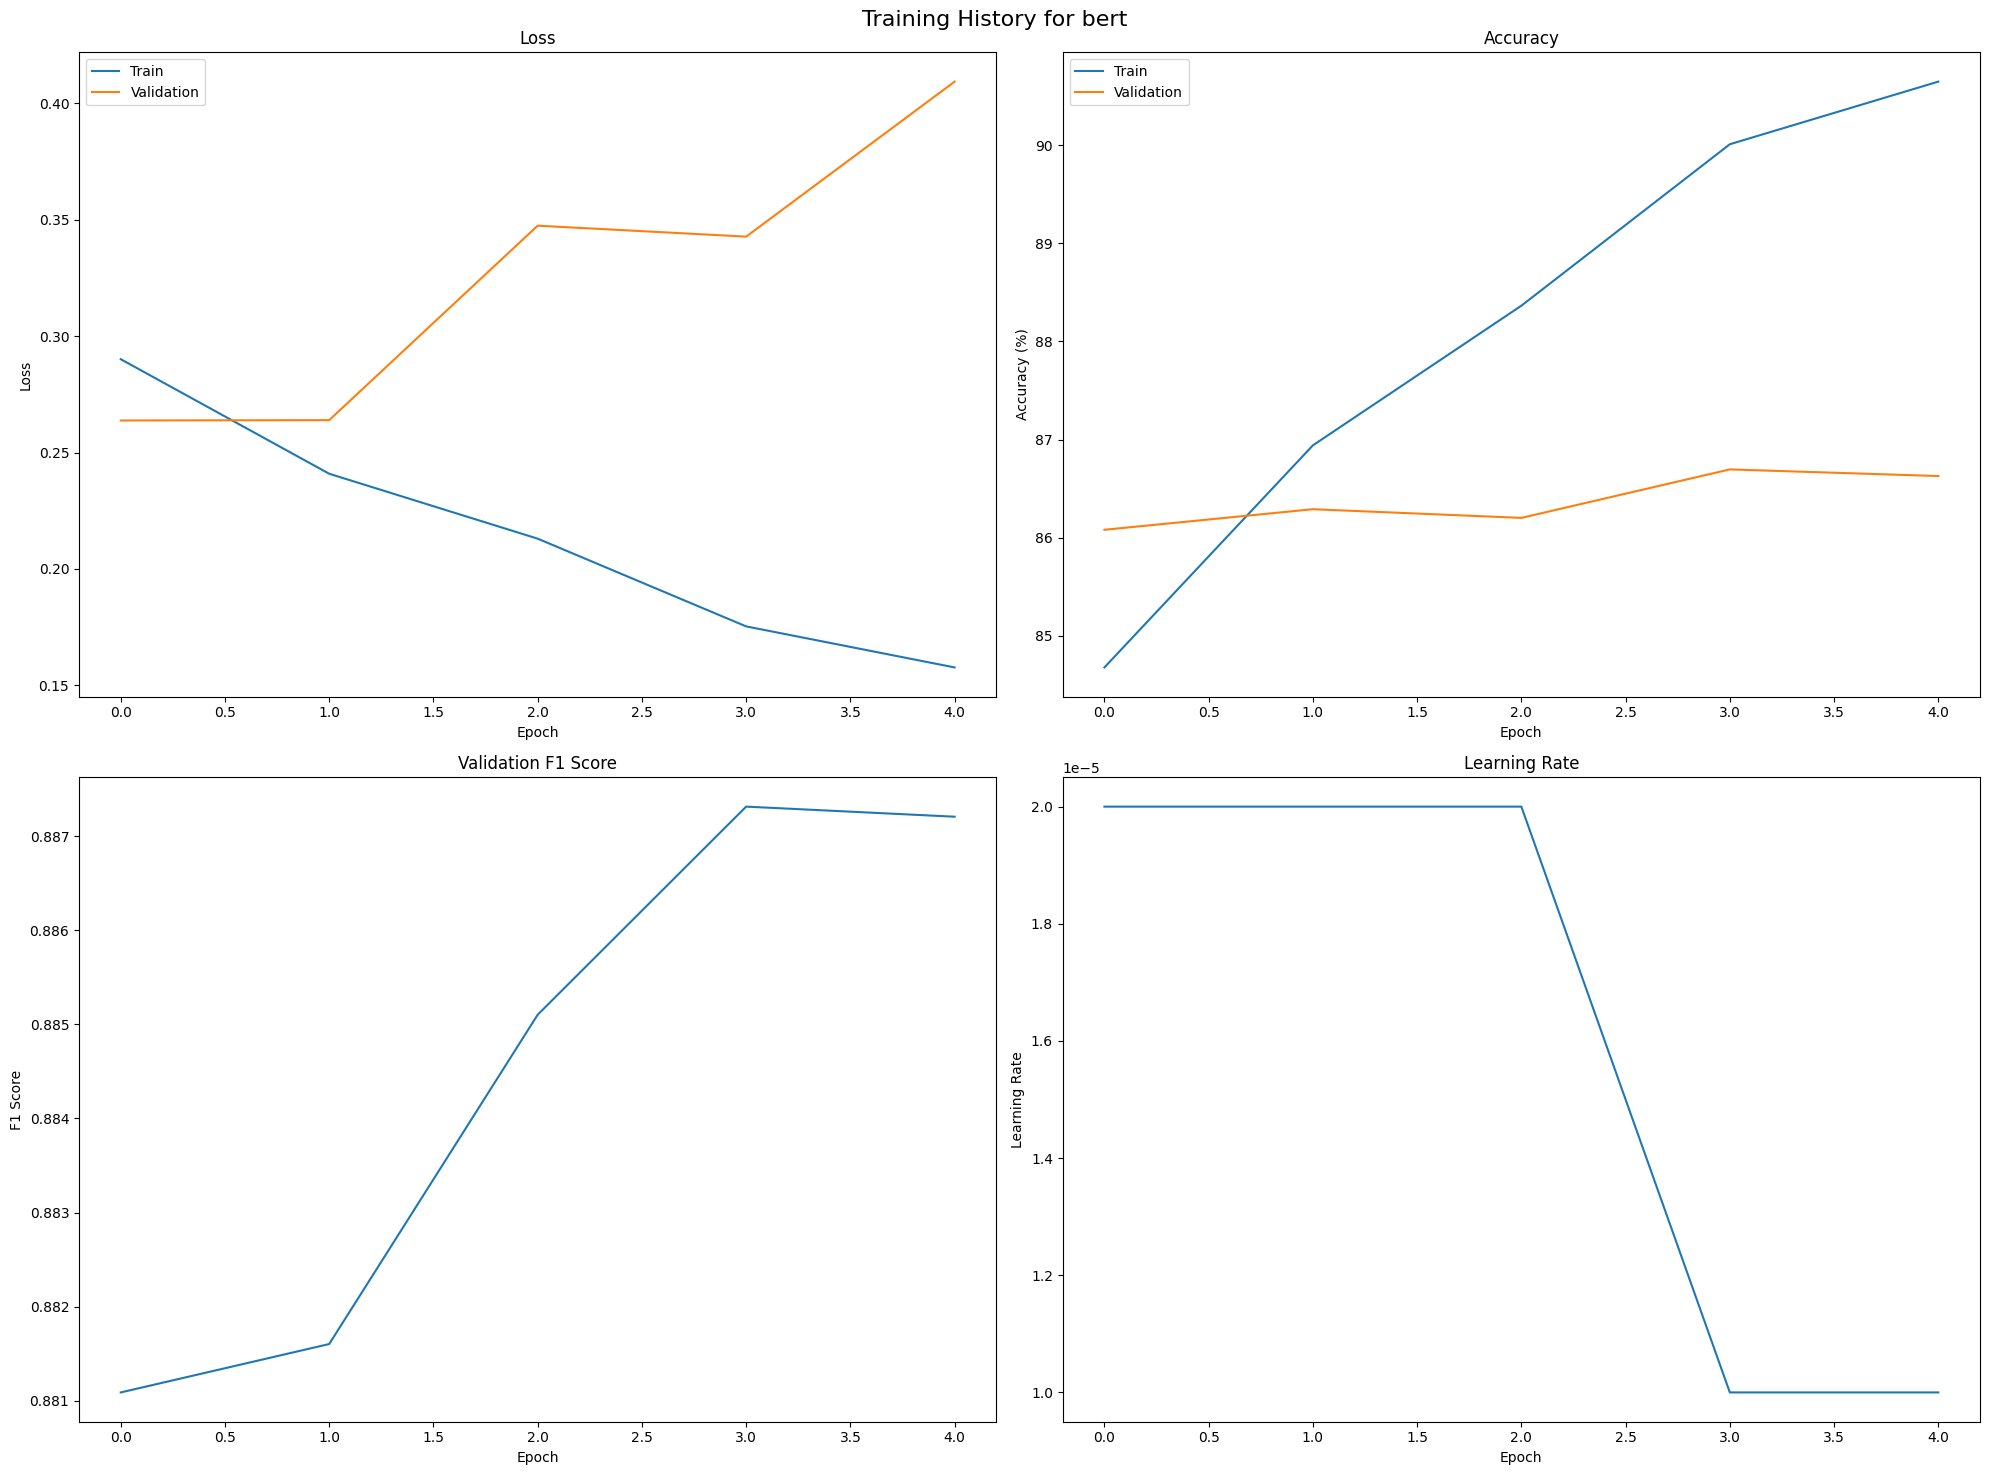

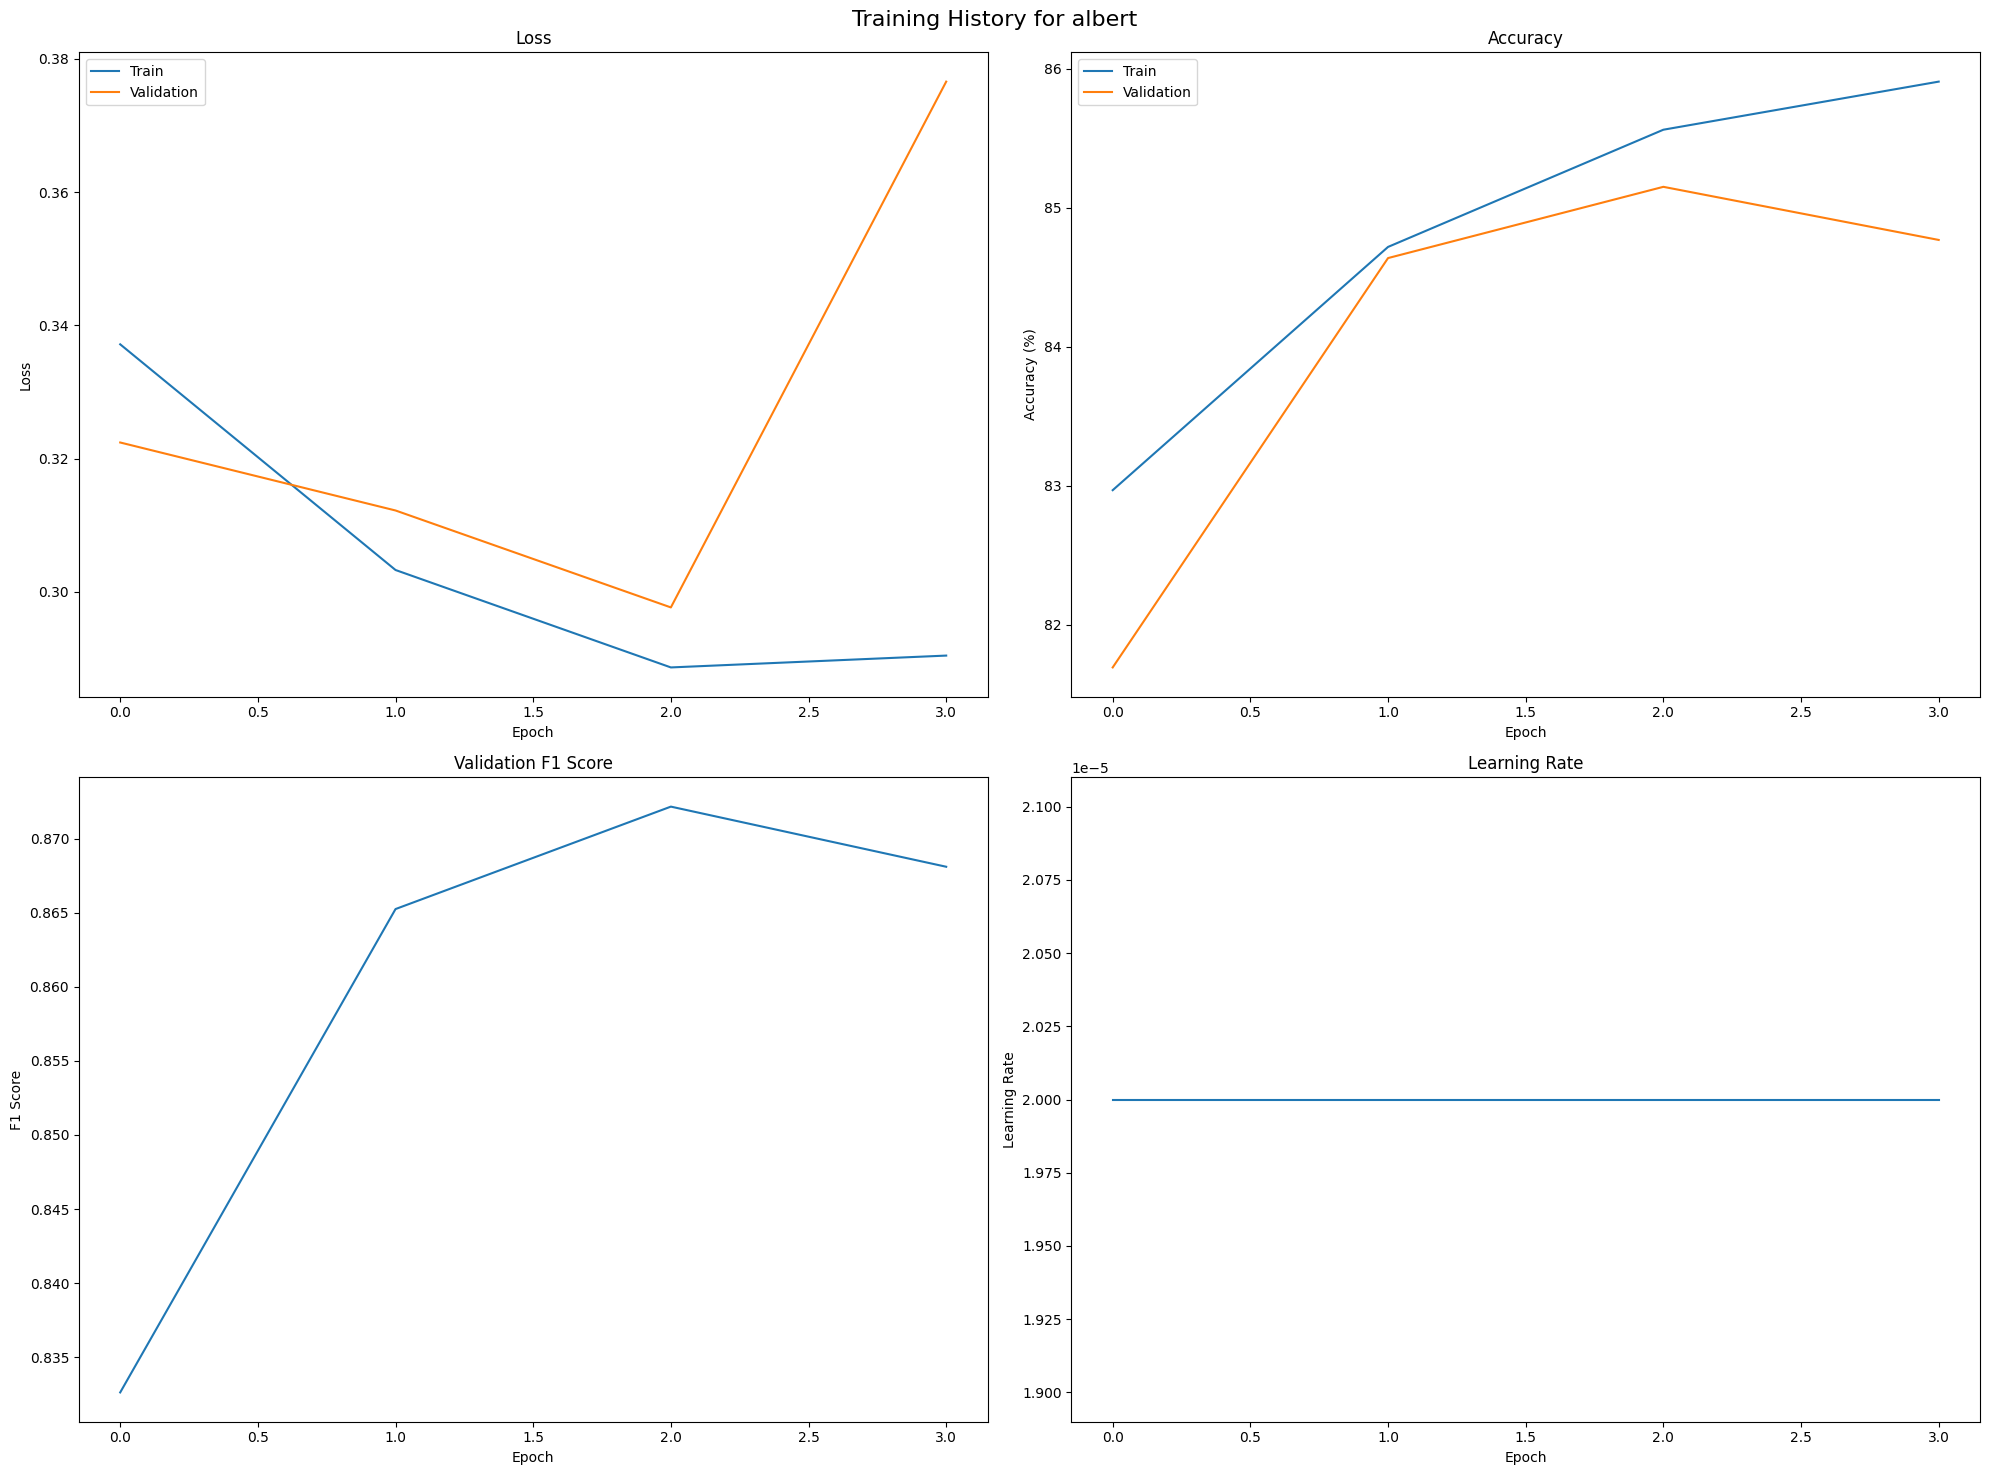

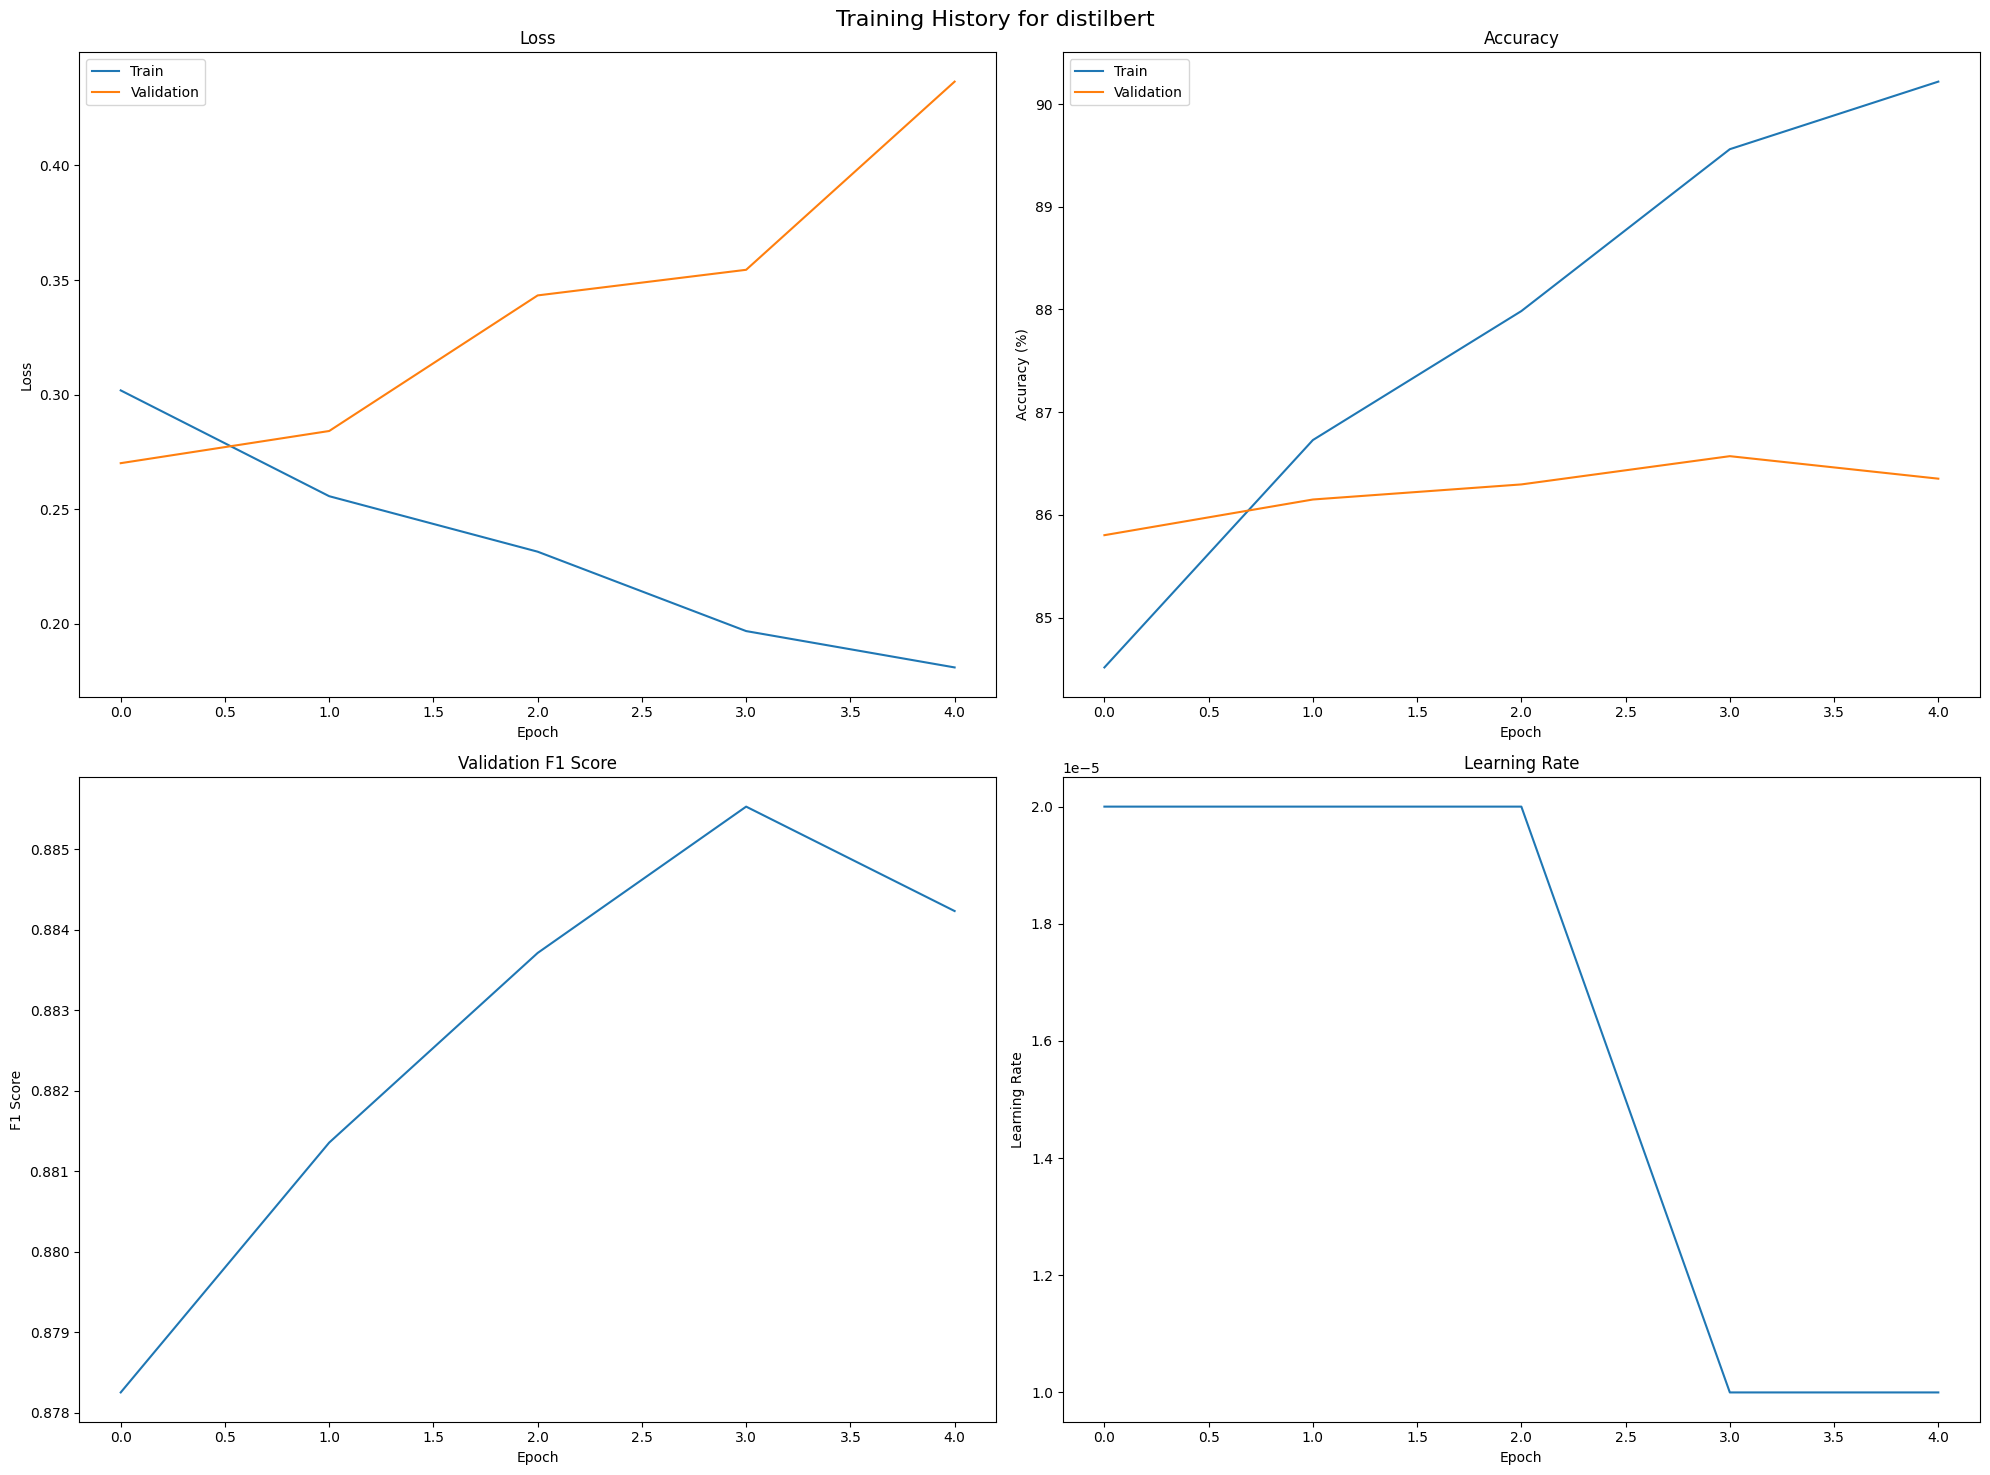

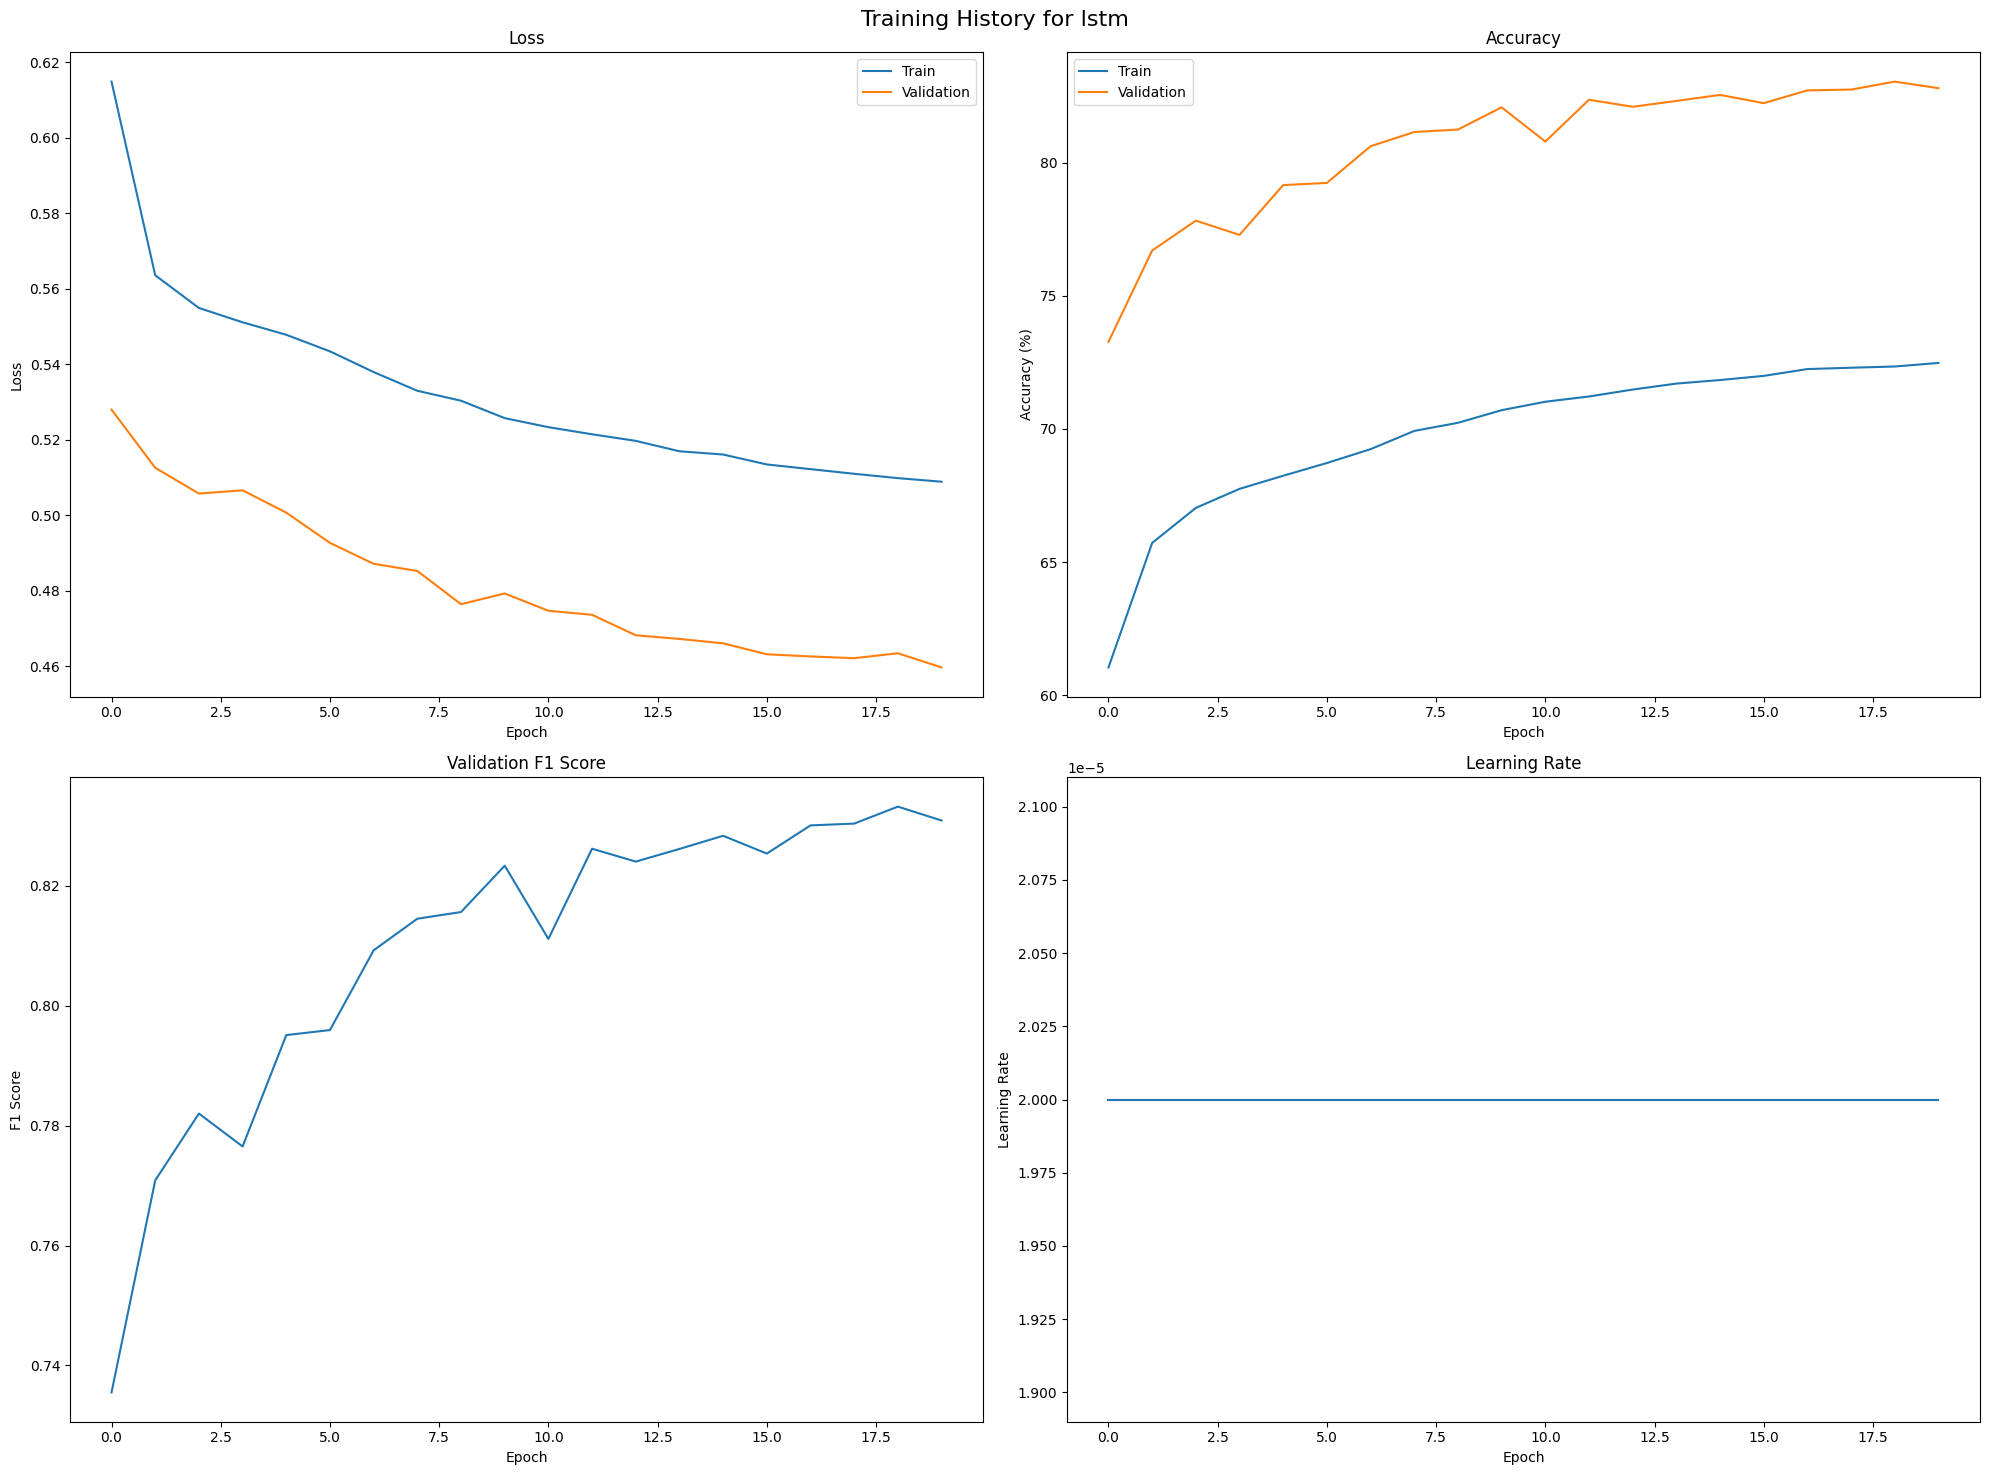

In [25]:
plot_training_history(results)

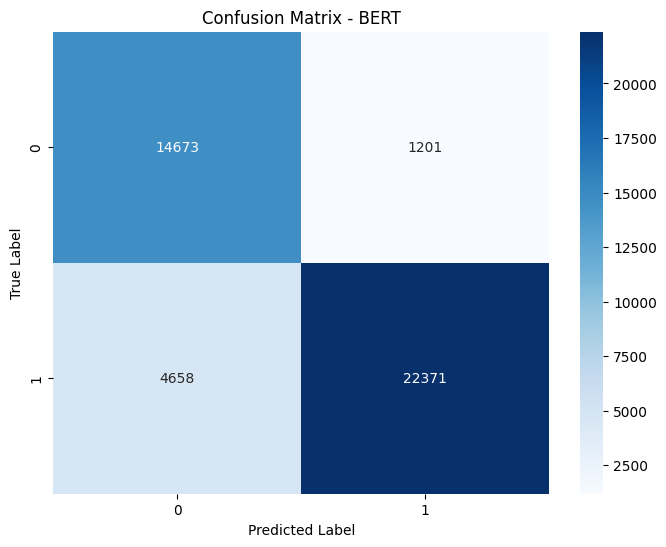

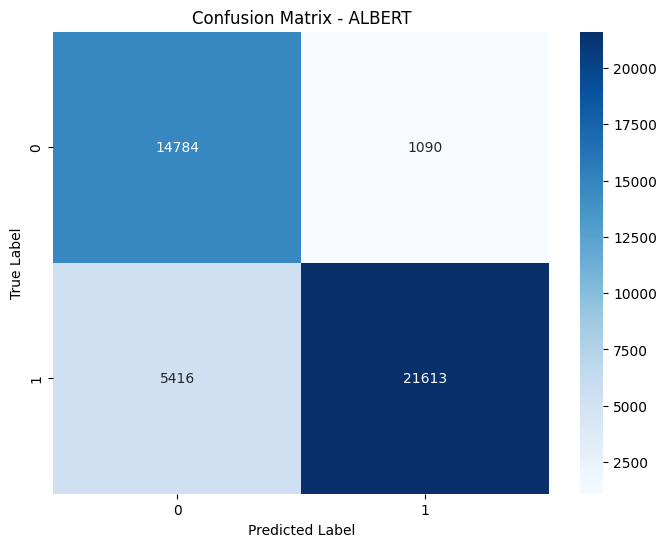

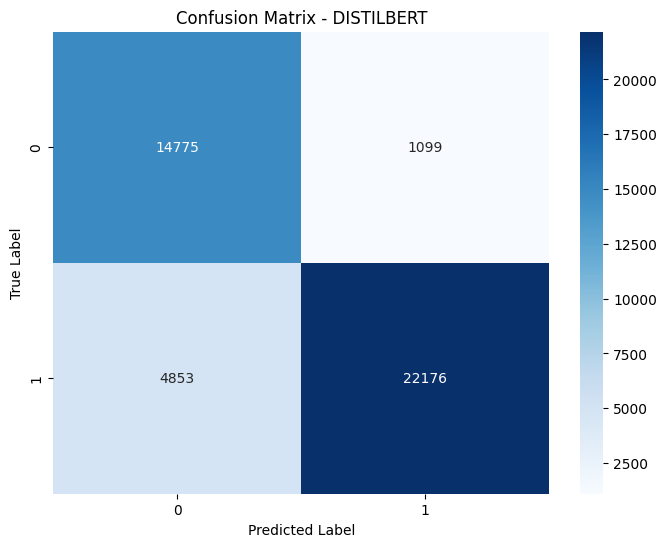

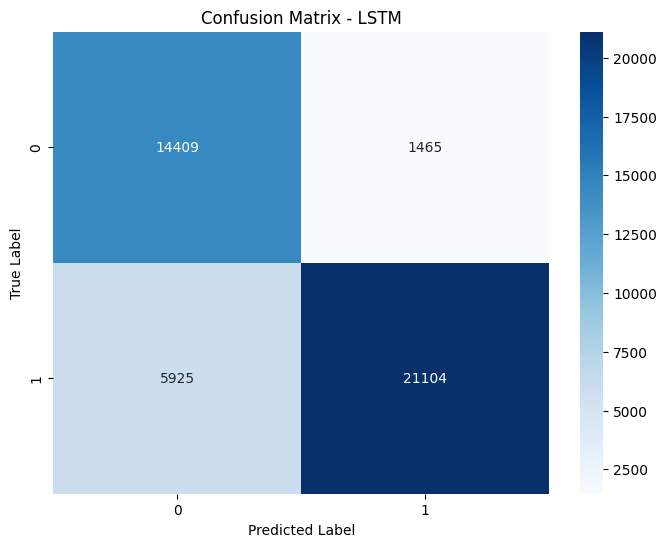

In [26]:
for model_name in models:
    true_labels = true_labels_dict[model_name]
    pred_labels = pred_labels_dict[model_name]
    plot_confusion_matrix(true_labels, pred_labels, model_name)